In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.stats import f_oneway
import matplotlib.pyplot as plt

In [2]:
# --- Output directory ---
os.makedirs("plots", exist_ok=True)

In [3]:
# --- Load data ---
df = pd.read_csv("customers.csv")
features = ["recency_days", "frequency", "monetary_value"]

In [4]:
# --- Scale ---
scaler = StandardScaler()
X = scaler.fit_transform(df[features])

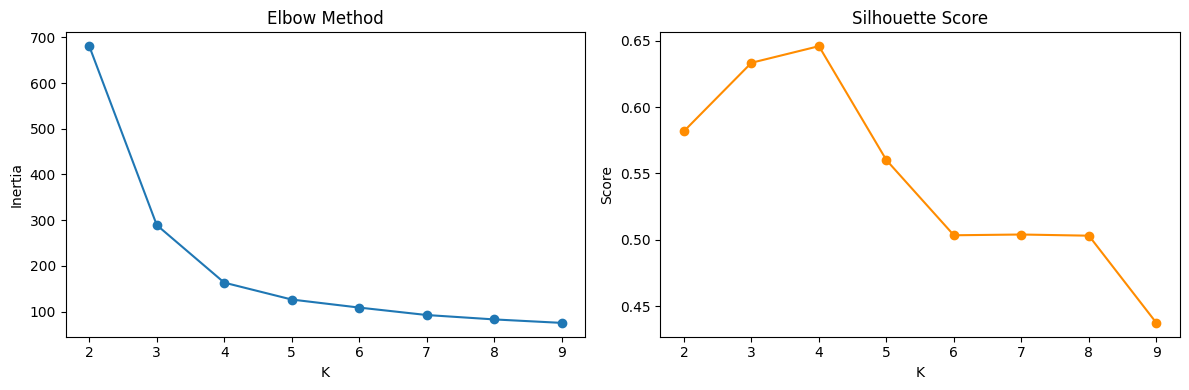

In [5]:
# --- Select K ---
k_range = range(2, 10)
inertias, scores = [], []

for k in k_range:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    scores.append(silhouette_score(X, labels))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(k_range, inertias, marker='o')
axes[0].set_title("Elbow Method")
axes[0].set_xlabel("K")
axes[0].set_ylabel("Inertia")
axes[1].plot(k_range, scores, marker='o', color='darkorange')
axes[1].set_title("Silhouette Score")
axes[1].set_xlabel("K")
axes[1].set_ylabel("Score")
plt.tight_layout()
plt.savefig("plots/kmeans_k_selection.png", dpi=150)
plt.show()
plt.close()

In [6]:
# --- Fit final model with chosen K ---
K_FINAL = 4
kmeans = KMeans(n_clusters=K_FINAL, init='k-means++', n_init=20, random_state=42)
df["cluster"] = kmeans.fit_predict(X)

In [7]:
# --- Profile ---
print(df.groupby("cluster")[features].mean().round(2))

         recency_days  frequency  monetary_value
cluster                                         
0               16.29      17.33          519.93
1              119.94       8.04          180.26
2               20.28       3.20           74.23
3              285.36       2.02           48.13


In [8]:
# --- Identify distinguishing features ---
print("\nANOVA — feature importance across clusters:")
for feature in features:
    groups = [df.loc[df["cluster"] == k, feature].values for k in range(K_FINAL)]
    f_stat, p_val = f_oneway(*groups)
    significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    print(f"  {feature:20s}  F={f_stat:8.2f}  p={p_val:.4f}  {significance}")


ANOVA — feature importance across clusters:
  recency_days          F= 4930.21  p=0.0000  ***
  frequency             F= 1052.62  p=0.0000  ***
  monetary_value        F= 2467.54  p=0.0000  ***


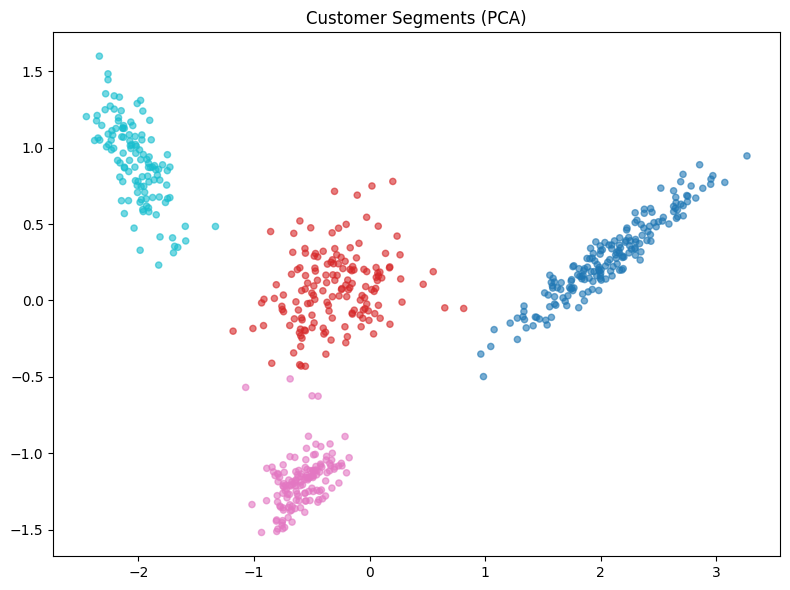

In [9]:
# --- Visualize ---
X_2d = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df["cluster"], cmap="tab10", alpha=0.6, s=20)
plt.title("Customer Segments (PCA)")
plt.tight_layout()
plt.savefig("plots/kmeans_customer_segments_pca.png", dpi=150)
plt.show()
plt.close()

In [10]:
# --- Label ---
label_map = {0: "Champions", 1: "At-Risk", 2: "Promising", 3: "Hibernating"}
df["segment"] = df["cluster"].map(label_map)
print(df["segment"].value_counts())

segment
Champions      180
At-Risk        156
Promising      144
Hibernating    120
Name: count, dtype: int64
